In [1]:
import cv2
import os
from ultralytics import YOLO
import cv2
import requests
from io import BytesIO
from PIL import Image, ImageOps, ImageEnhance

In [2]:
def load_image(image_path_or_url):
    """Improved image loading with better error handling"""
    try:
        if image_path_or_url.startswith(('http://', 'https://')):
            headers = {
                'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
                'Accept': 'image/webp,image/apng,image/*,*/*;q=0.8'
            }
            session = requests.Session()
            response = session.get(image_path_or_url, 
                                 headers=headers, 
                                 stream=True, 
                                 timeout=10)
            response.raise_for_status()
            
            # Verify content is actually an image
            if 'image' not in response.headers.get('Content-Type', ''):
                raise ValueError("URL does not point to an image")
                
            img = Image.open(BytesIO(response.content)).convert('RGB')
        else:
            img = Image.open(image_path_or_url).convert('RGB')
        
        # Display image and prediction
        plt.figure(figsize=(3, 2))
        plt.imshow(img)
        plt.title(f"Image Prediction")
        plt.axis('off')
        plt.show()
        
        return img
    except requests.exceptions.RequestException as e:
        raise ValueError(f"URL error: {str(e)}")
    except IOError as e:
        raise ValueError(f"Image loading error: {str(e)}")
    except Exception as e:
        raise ValueError(f"Unexpected error: {str(e)}")
        
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import numpy as np

def show_predictions(img, results, class_names):
    """
    Display image with bounding boxes and class names from Ultralytics Results object.
    Each class is shown in a different color.

    Parameters:
    - img: The image array (e.g., NumPy array or PIL image)
    - results: Ultralytics Results object from model.predict(img)
    - class_names: Dictionary mapping class_id to class_name (e.g., model.names)
    """
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    boxes = results[0].boxes.xyxy.cpu().numpy()
    class_ids = results[0].boxes.cls.cpu().numpy().astype(int)
    scores = results[0].boxes.conf.cpu().numpy()

    unique_classes = np.unique(class_ids)
    cmap = cm.get_cmap('tab20', len(unique_classes))
    class_colors = {cls_id: cmap(i) for i, cls_id in enumerate(unique_classes)}

    for box, class_id, score in zip(boxes, class_ids, scores):
        x1, y1, x2, y2 = box
        color = class_colors[class_id]
        class_name = class_names.get(class_id, f"Class {class_id}")

        # Draw bounding box
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor=color, facecolor='none')
        ax.add_patch(rect)

        # Add label with class name
        label = f"{class_name} ({score:.2f})"
        ax.text(x1, y1 - 10, label, color='white', fontsize=9,
                bbox=dict(facecolor=color, alpha=0.7))

    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [3]:

def crop_predicted_objects(image, results):
    """
    Crops detected objects from an image based on YOLO prediction results and returns them with metadata.

    Args:
        image (np.ndarray): The original image read by OpenCV.
        results (ultralytics.yolo.engine.results.Results): The results object from model.predict().

    Returns:
        tuple: A tuple containing three elements:
            - list[np.ndarray]: A list of cropped images.
            - list[str]: A list of class names for each cropped image.
            - list[float]: A list of confidence scores for each detection.
        Returns empty lists if no objects are detected.
    """
    cropped_images = []
    class_names = []
    confidences = []
    
    # Check if there are any detections
    if results.boxes is None:
        return cropped_images, class_names, confidences
    
    # Get the names of the classes from the model
    names = results.names
    
    # Get the bounding boxes, confidence scores, and class IDs from the results object
    boxes = results.boxes
    confs = boxes.conf
    class_ids = boxes.cls

    # Iterate through each detected object
    for i, box in enumerate(boxes):
        # Get the bounding box coordinates in xyxy format
        x1, y1, x2, y2 = box.xyxy[0].tolist()
        
        # Convert coordinates to integers
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        
        # Ensure coordinates are within image boundaries
        height, width = image.shape[:2]
        x1 = max(0, x1)
        y1 = max(0, y1)
        x2 = min(width, x2)
        y2 = min(height, y2)

        # Crop the image only if the bounding box is valid
        if x2 > x1 and y2 > y1:
            cropped_image = image[y1:y2, x1:x2]
            
            cropped_images.append(cropped_image)
            
            # Get the class name and confidence for this detection
            class_id = int(class_ids[i].item())
            class_name = names[class_id]
            confidence = confs[i].item()
            
            class_names.append(class_name)
            confidences.append(confidence)
            
    return cropped_images, class_names, confidences

### OCR Related Functions

In [4]:
def get_sorted_label_string(model, results, sort_by='x'):
    """
    Extracts class labels from model results and returns a string
    sorted by the x_min or y_min of each bounding box, along with confidence details.

    Parameters:
        model: the detection model (used to map class indices to names)
        results: model output (can be list or single Results object)
        sort_by: 'x' for left-to-right, 'y' for top-to-bottom

    Returns:
        tuple:
            - str: concatenated class labels (e.g., "ABC123")
            - list[dict]: [{'label': 'A', 'confidence': 0.98}, ...]
            - float: average confidence
    """
    # Handle list of results (common when model() is called on image)
    if isinstance(results, list):
        if len(results) == 0:
            return "", [], 0.0
        boxes = results[0].boxes
    else:
        boxes = results.boxes

    # If no boxes detected
    if boxes is None or len(boxes) == 0:
        return "", [], 0.0

    # Extract data
    xyxy = boxes.xyxy.cpu().numpy()      # [N, 4] -> x1, y1, x2, y2
    cls_ids = boxes.cls.cpu().numpy()    # [N]
    confs = boxes.conf.cpu().numpy()     # [N]

    # Choose sort key: x_min (index 0) or y_min (index 1)
    sort_index = 0 if sort_by == 'x' else 1
    sort_key = xyxy[:, sort_index]

    # Combine detection data
    detections = []
    for i in range(len(boxes)):
        detections.append({
            'cls_id': int(cls_ids[i]),
            'confidence': float(confs[i]),
            'x_min': float(xyxy[i, 0]),
            'y_min': float(xyxy[i, 1])
        })

    # Sort by sort_key (x_min or y_min), ascending
    sorted_detections = sorted(detections, key=lambda d: d['x_min' if sort_by == 'x' else 'y_min'])

    # Generate label string
    label_str = ''.join(model.names[d['cls_id']] for d in sorted_detections)

    # Detailed list with label and confidence
    detailed_labels = [
        {'label': model.names[d['cls_id']], 'confidence': d['confidence']}
        for d in sorted_detections
    ]

    # Calculate average confidence
    avg_confidence = sum(d['confidence'] for d in sorted_detections) / len(sorted_detections)

    return label_str, detailed_labels, avg_confidence

def preprocess_image_for_ocr(input_image, scale_factor=2, denoise_strength=10, sharpness_factor=1.5):
    """
    Preprocess an image for OCR that accepts both PIL Images and NumPy arrays.
    
    Args:
        input_image (PIL.Image.Image or np.ndarray): Input image
        scale_factor (int): Factor to upscale the image. Default 2.
        denoise_strength (int): Strength for denoising. Default 10.
        sharpness_factor (float): Factor for sharpening. Default 1.5.
    
    Returns:
        numpy array: Processed image as a PIL Image object.
    """
    # Import OpenCV inside the function
    import cv2
    
    # Convert to PIL Image if it's a NumPy array
    if isinstance(input_image, np.ndarray):
        # Convert BGR to RGB if it's a color image
        if len(input_image.shape) == 3 and input_image.shape[2] == 3:
            input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
        img = Image.fromarray(input_image)
    else:
        img = input_image.copy()
    
    # 1. Convert to grayscale (Luminosity mode)
    # if img.mode != 'L':
    #     img = img.convert('L')
    
    # 2. Resize (Upscale) using LANCZOS filter
    if scale_factor != 1:
        new_width = int(img.width * scale_factor)
        new_height = int(img.height * scale_factor)
        img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
    
    # 3. Convert to numpy array for OpenCV denoising if needed
    if denoise_strength > 0:
        import cv2
        img_np = np.array(img)
        denoised_np = cv2.fastNlMeansDenoising(img_np, h=denoise_strength, 
                                              templateWindowSize=7, 
                                              searchWindowSize=21)
        img = Image.fromarray(denoised_np)
    
    # 4. Enhance contrast
    img = ImageOps.autocontrast(img, cutoff=2)
    
    # 5. Apply sharpening
    if sharpness_factor > 1.0:
        enhancer = ImageEnhance.Sharpness(img)
        img = enhancer.enhance(sharpness_factor)
        
    # # 6. Convert to black and white (binary)
    # img_bw = img.convert('L')  # Ensure grayscale
    # threshold = 128
    # # Apply threshold: pixels > threshold become white (255), else black (0)
    # binary = img_bw.point(lambda p: 255 if p > threshold else 0)
    
    # # Convert back to RGB
    # img = Image.merge('RGB', (binary, binary, binary))
    
    return np.array(img)

def remove_overlapping_detections(results, iou_threshold=0.5):
    """
    Removes overlapping OCR detections based on IoU.
    Keeps the one with higher confidence in each overlap group.

    Args:
        results: YOLO Results object or list of Results
        iou_threshold (float): IoU threshold (e.g., 0.5 = 50% overlap)

    Returns:
        Results: New Results object with overlapping boxes removed
    """
    from ultralytics.engine.results import Results
    import torch
    import numpy as np

    # Handle list input
    if isinstance(results, list):
        result = results[0]
    else:
        result = results

    if result.boxes is None or len(result.boxes) == 0:
        return result

    # Get data
    boxes_xyxy = result.boxes.xyxy.cpu().numpy()  # (N, 4)
    scores = result.boxes.conf.cpu().numpy()      # (N,)
    classes = result.boxes.cls.cpu().numpy()      # (N,)
    orig_img = result.orig_img                    # needed
    path = result.path
    names = result.names

    # Sort by confidence descending
    indices = np.argsort(-scores)
    keep = []

    def calculate_iou(box1, box2):
        x1 = max(box1[0], box2[0])
        y1 = max(box1[1], box2[1])
        x2 = min(box1[2], box2[2])
        y2 = min(box1[3], box2[3])
        if x2 <= x1 or y2 <= y1:
            return 0.0
        inter_area = (x2 - x1) * (y2 - y1)
        area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
        area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
        union_area = area1 + area2 - inter_area
        return inter_area / union_area if union_area > 0 else 0.0

    # Greedy NMS: keep high-confidence, remove overlapping
    for i in indices:
        include = True
        for k in keep:
            if calculate_iou(boxes_xyxy[i], boxes_xyxy[k]) > iou_threshold:
                include = False
                break
        if include:
            keep.append(i)

    # Reconstruct box tensor: [x1, y1, x2, y2, conf, cls]
    if len(keep) == 0:
        # Empty detection
        new_boxes = torch.empty((0, 6), device=result.boxes.data.device)
    else:
        new_boxes = result.boxes.data[keep]  # ✅ This already has shape [N, 6]

    # ✅ Correct: Only pass valid parameters
    filtered_result = Results(
        orig_img=orig_img,
        path=path,
        names=names,
        boxes=new_boxes  # ← This is the only required detection input
    )

    return filtered_result

In [5]:
model_cnr_path = "./Deploy/assets/cnr.pt"
print(model_cnr_path)
model_cnr = YOLO(model_cnr_path)

model_ocr_path = "./Deploy/assets/ocr.pt"
print(model_ocr_path)
model_ocr = YOLO(model_ocr_path)

./Deploy/assets/cnr.pt
./Deploy/assets/ocr.pt


In [21]:
def process(url_image):
    img = load_image(url_image)
    
    results = model_cnr.predict(img, conf=0.4)  # Filter classes by ID
        
    boxes = results[0].boxes
    class_ids = boxes.cls.cpu().numpy().astype(int)
    confidences = boxes.conf.cpu().numpy()
    
    for cls_id, conf in zip(class_ids, confidences):
        class_name = model_cnr.names.get(cls_id, f"Class {cls_id}")
        print(f"- {class_name}: {conf:.2f}")
    
    show_predictions(img, results, model_cnr.names)
    
    cropped_images, names, confidences = crop_predicted_objects(np.array(img), results[0])

    print("------- ORIGINAL CROP RESULT -----------")
    for i, cropped_img in enumerate(cropped_images):
        plt.figure()
        plt.imshow(cropped_img)
        plt.title(f"{names[i]}:{confidences[i]}")
        plt.axis('off') # Hide axes
        plt.show()
    
    #OCR Process
    
    print("------- PREPROCESS CROP RESULT -----------")
    for i, cropped_img in enumerate(cropped_images):
        # Convert from BGR (OpenCV) to RGB (Matplotlib)
        preproc_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
        # Preprocess image for better letter prediction result
        preproc_img = preprocess_image_for_ocr(preproc_img)
        ocr_results = model_ocr.predict(preproc_img,conf=0.4)
        # Remove overlapping object letter
        ocr_results = remove_overlapping_detections(ocr_results, iou_threshold=0.5)
    
        orientation = 'x'
        if (names[i].startswith("V ")):
            orientation = 'y'
        text, text_lbls, avg_conf = get_sorted_label_string(model_ocr, ocr_results, sort_by=orientation)
        print(f"letters predictions : {text_lbls}")
        print(f"text : {text}")
        plt.figure()
        plt.imshow(preproc_img)
        plt.title(f"{names[i]}, conf: {confidences[i]:.2f}\nText: {text}, conf: {avg_conf:.2f}")
        plt.axis('off') # Hide axes
        plt.show()

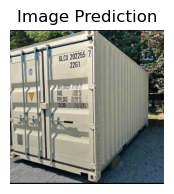


0: 640x640 1 Serial Number, 1 Owner Prefix, 1 ISO6346, 26.9ms
Speed: 6.6ms preprocess, 26.9ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)
- ISO6346: 0.93
- Serial Number: 0.87
- Owner Prefix: 0.75


C:\Users\budik\AppData\Local\Temp\ipykernel_28828\3451555728.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_classes))


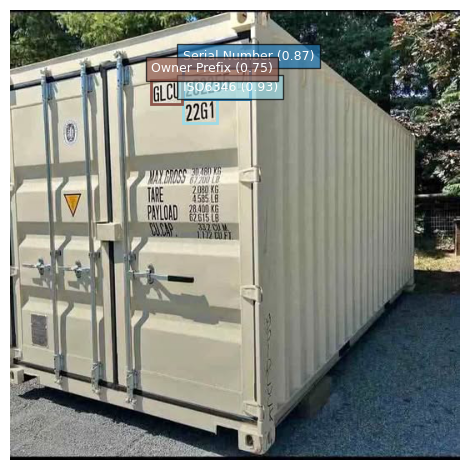

------- ORIGINAL CROP RESULT -----------


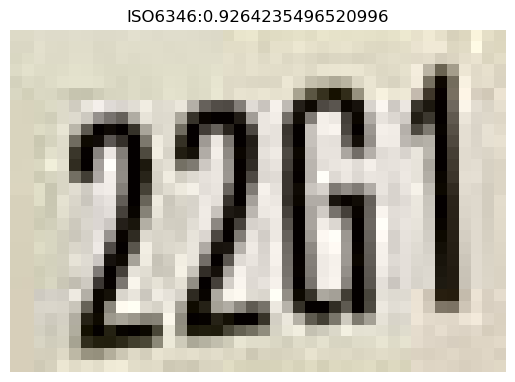

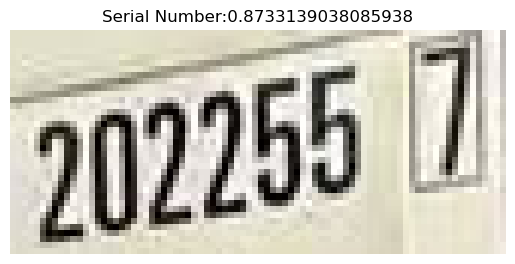

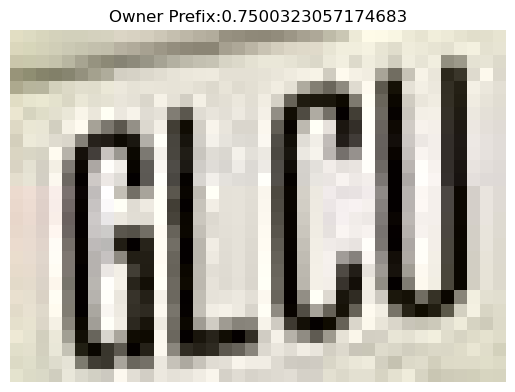

------- PREPROCESS CROP RESULT -----------

0: 448x640 1 1, 2 2s, 1 G, 20.5ms
Speed: 3.3ms preprocess, 20.5ms inference, 3.2ms postprocess per image at shape (1, 3, 448, 640)
letters predictions : [{'label': '2', 'confidence': 0.9429367780685425}, {'label': '2', 'confidence': 0.9399017691612244}, {'label': 'G', 'confidence': 0.9619090557098389}, {'label': '1', 'confidence': 0.9119762182235718}]
text : 22G1


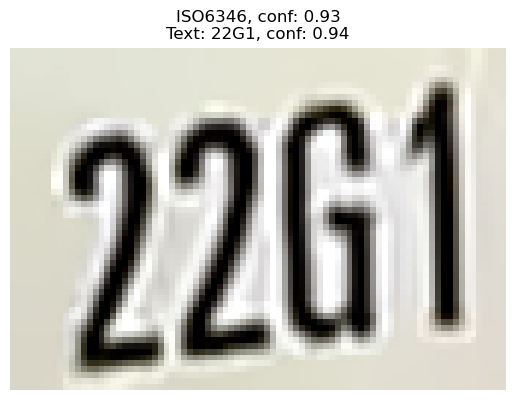


0: 320x640 1 0, 3 2s, 2 5s, 1 7, 17.3ms
Speed: 2.7ms preprocess, 17.3ms inference, 2.3ms postprocess per image at shape (1, 3, 320, 640)
letters predictions : [{'label': '2', 'confidence': 0.9719412326812744}, {'label': '0', 'confidence': 0.9783427119255066}, {'label': '2', 'confidence': 0.9393832683563232}, {'label': '2', 'confidence': 0.9407366514205933}, {'label': '5', 'confidence': 0.9532841444015503}, {'label': '5', 'confidence': 0.9469895958900452}, {'label': '7', 'confidence': 0.9429863095283508}]
text : 2022557


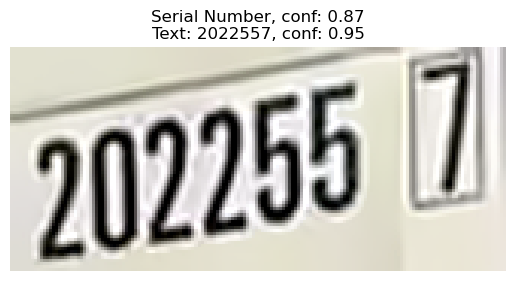


0: 480x640 1 C, 1 G, 1 L, 1 U, 21.2ms
Speed: 3.5ms preprocess, 21.2ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)
letters predictions : [{'label': 'G', 'confidence': 0.9410393238067627}, {'label': 'L', 'confidence': 0.921108603477478}, {'label': 'C', 'confidence': 0.8012003898620605}, {'label': 'U', 'confidence': 0.8994749784469604}]
text : GLCU


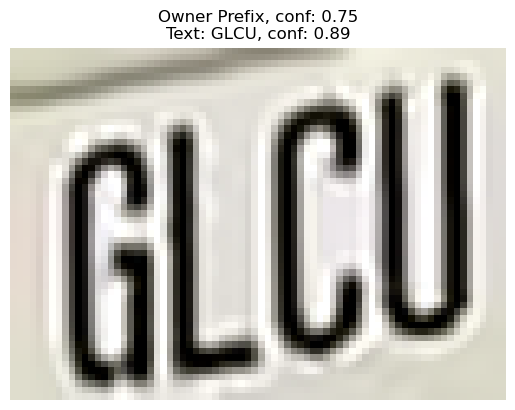

In [22]:
url_image = "https://scontent.fcgk43-1.fna.fbcdn.net/v/t45.5328-4/529235461_1426383392001949_7870074758301928627_n.jpg?stp=c85.0.540.540a_dst-jpg_p180x540_tt6&_nc_cat=111&ccb=1-7&_nc_sid=247b10&_nc_eui2=AeHxzYqLTd46Ubeg0L8K8BNvc7r7jqKWoqNzuvuOopaio_3gCd9_gVEeXK6W8UwGkYg&_nc_ohc=YiryliQqNbYQ7kNvwEiAWyZ&_nc_oc=Adltdg-m27IZwYgr1wCsP9Z5IXA0Zh8mW6pSPg4D8YEmz1w7pWXIdN6sOPhVjlKMfYQ&_nc_zt=23&_nc_ht=scontent.fcgk43-1.fna&_nc_gid=0bAV0Y5kN1EwopQoR6J8FQ&oh=00_AfY89RNDcD82zjdcTiFyzDckGnruN9BzuFYQZaVqX8vaTA&oe=68C624DA"
process(url_image)

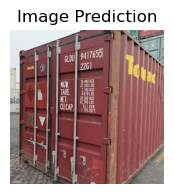


0: 640x640 1 Serial Number, 1 Owner Prefix, 1 ISO6346, 25.9ms
Speed: 6.1ms preprocess, 25.9ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 640)
- ISO6346: 0.89
- Owner Prefix: 0.85
- Serial Number: 0.72


C:\Users\budik\AppData\Local\Temp\ipykernel_28828\3451555728.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_classes))


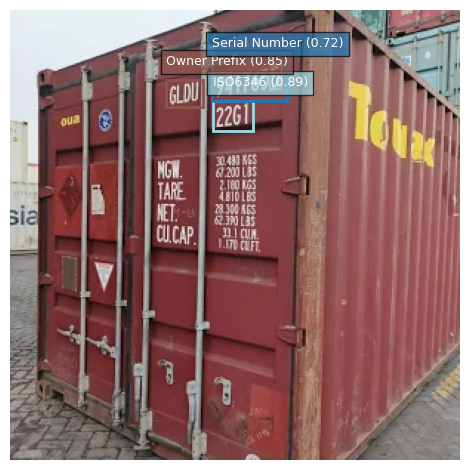

------- ORIGINAL CROP RESULT -----------


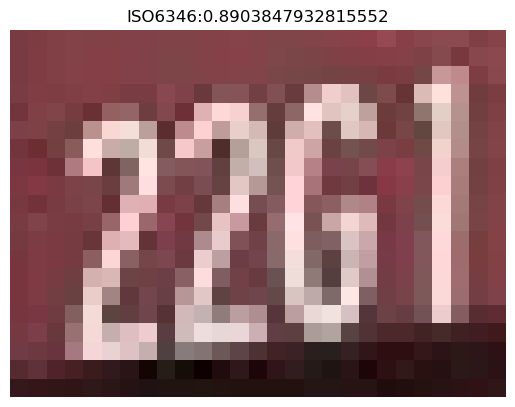

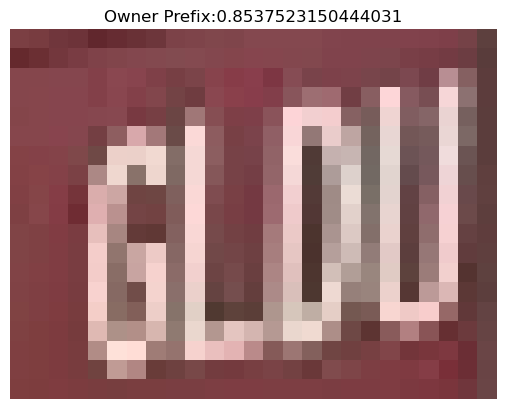

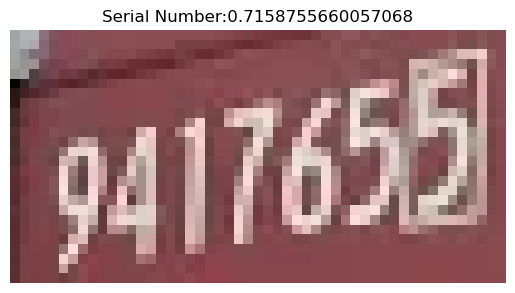

------- PREPROCESS CROP RESULT -----------

0: 480x640 1 1, 2 2s, 1 G, 19.4ms
Speed: 4.4ms preprocess, 19.4ms inference, 3.1ms postprocess per image at shape (1, 3, 480, 640)
letters predictions : [{'label': '2', 'confidence': 0.9238808155059814}, {'label': '2', 'confidence': 0.9107480645179749}, {'label': 'G', 'confidence': 0.9508109092712402}, {'label': '1', 'confidence': 0.8594434261322021}]
text : 22G1


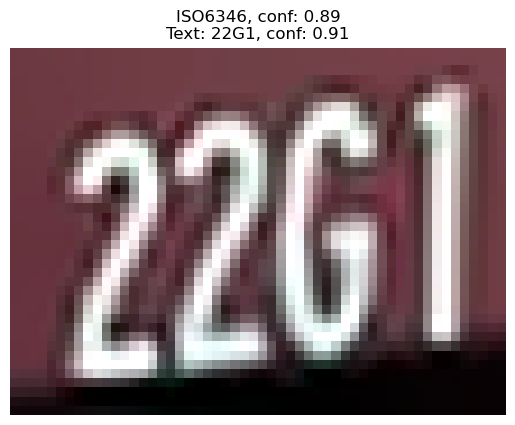


0: 512x640 1 D, 1 G, 1 L, 1 U, 21.5ms
Speed: 3.6ms preprocess, 21.5ms inference, 2.1ms postprocess per image at shape (1, 3, 512, 640)
letters predictions : [{'label': 'G', 'confidence': 0.9121413230895996}, {'label': 'L', 'confidence': 0.95316481590271}, {'label': 'D', 'confidence': 0.9782950282096863}, {'label': 'U', 'confidence': 0.8316829800605774}]
text : GLDU


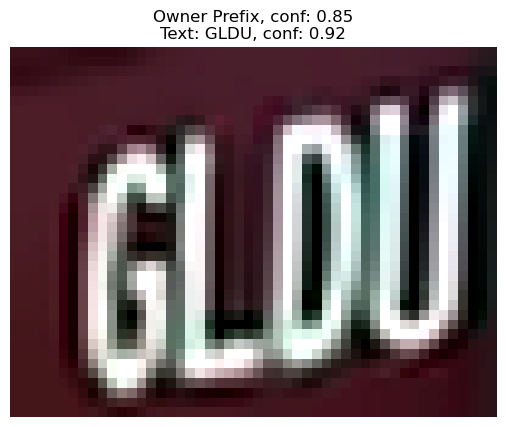


0: 352x640 1 1, 1 4, 2 5s, 1 6, 1 7, 1 9, 18.4ms
Speed: 2.8ms preprocess, 18.4ms inference, 2.1ms postprocess per image at shape (1, 3, 352, 640)
letters predictions : [{'label': '9', 'confidence': 0.9298266768455505}, {'label': '4', 'confidence': 0.945846676826477}, {'label': '1', 'confidence': 0.7214307188987732}, {'label': '7', 'confidence': 0.9514208436012268}, {'label': '6', 'confidence': 0.9742916226387024}, {'label': '5', 'confidence': 0.961148738861084}, {'label': '5', 'confidence': 0.9334397315979004}]
text : 9417655


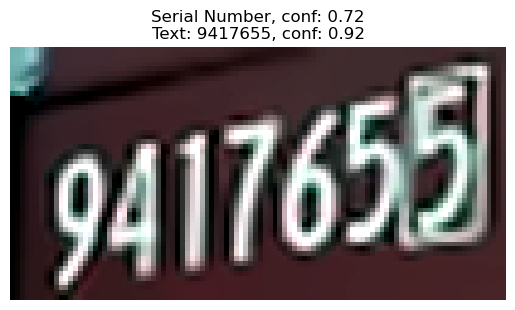

In [23]:
process("https://encrypted-tbn3.gstatic.com/shopping?q=tbn:ANd9GcTYczU536FVDI3LHQHh6M9K4J29Y_Wi9AKqVtd0ltKiQkdGc3qlLevWNNTU0w6iphA5lgqSnB5BbS7sUZgf7-2AYc2K2bCHejc3NAO-XwAGb_v2ieZwvfHPWQwVkw&usqp=CAc")

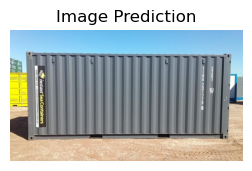


0: 384x640 1 V Serial Number, 1 V Owner Prefix, 1 V ISO6346, 19.0ms
Speed: 3.2ms preprocess, 19.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
- V Serial Number: 0.74
- V Owner Prefix: 0.60
- V ISO6346: 0.59


C:\Users\budik\AppData\Local\Temp\ipykernel_28828\3451555728.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(unique_classes))


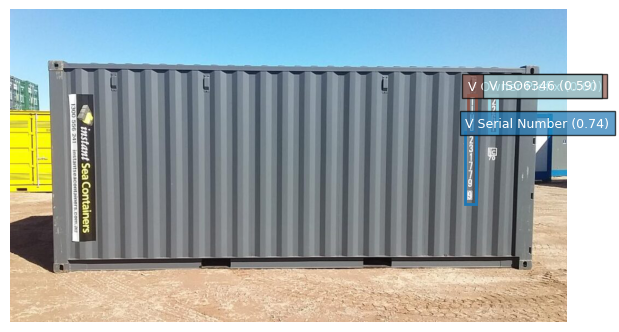

------- ORIGINAL CROP RESULT -----------


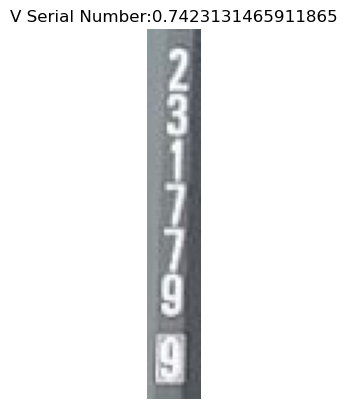

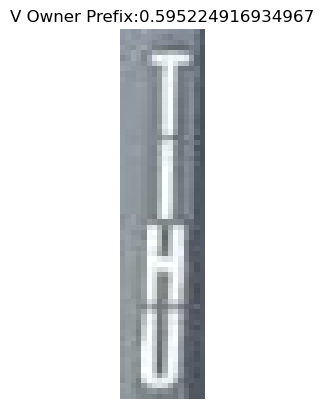

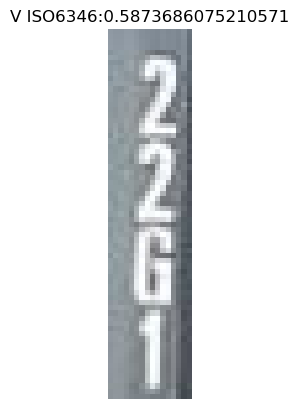

------- PREPROCESS CROP RESULT -----------

0: 640x96 1 1, 1 2, 1 3, 2 7s, 2 9s, 13.8ms
Speed: 1.9ms preprocess, 13.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 96)
letters predictions : [{'label': '2', 'confidence': 0.9040015339851379}, {'label': '3', 'confidence': 0.9598193168640137}, {'label': '1', 'confidence': 0.9707856178283691}, {'label': '7', 'confidence': 0.9587033987045288}, {'label': '7', 'confidence': 0.9406121969223022}, {'label': '9', 'confidence': 0.9577592611312866}, {'label': '9', 'confidence': 0.9325058460235596}]
text : 2317799


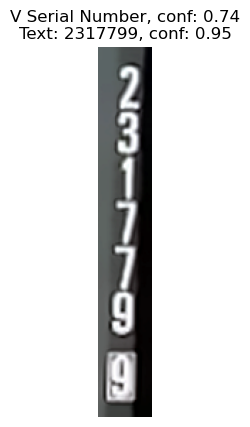


0: 640x160 1 H, 1 I, 1 N, 1 T, 1 U, 47.1ms
Speed: 2.0ms preprocess, 47.1ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 160)
letters predictions : [{'label': 'T', 'confidence': 0.9618867039680481}, {'label': 'I', 'confidence': 0.9297746419906616}, {'label': 'H', 'confidence': 0.5066316723823547}, {'label': 'U', 'confidence': 0.9306360483169556}]
text : TIHU


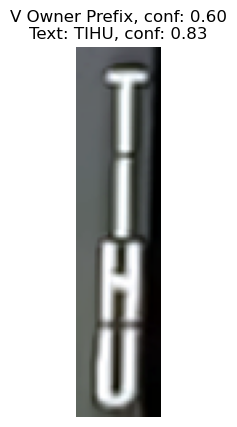


0: 640x160 1 1, 2 2s, 1 G, 38.1ms
Speed: 2.8ms preprocess, 38.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 160)
letters predictions : [{'label': '2', 'confidence': 0.9365969300270081}, {'label': '2', 'confidence': 0.9481676816940308}, {'label': 'G', 'confidence': 0.8929409384727478}, {'label': '1', 'confidence': 0.7654204964637756}]
text : 22G1


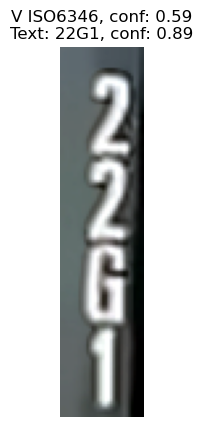

In [24]:
process("https://instantseacontainers.com.au/wp-content/uploads/2023/05/20gp-Sea-Container.jpg")

## End of Script